In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
from IPython.display import display
IMAGE_WIDTH = "1000"

In [2]:
def one_hot_encode(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    dummies = pd.get_dummies(df[feature], prefix=feature)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop([feature], axis=1)

    return(df)

# 0. Read dataset

### Read full dataset

In [3]:
dataset = pd.read_json("usersessions/dataset.json")
dataset["is_joe"] = (dataset["user_id"] == 0).astype(int)
print(dataset)
print(dataset.info())
print(dataset.columns)
print(dataset.shape)

       browser          os locale  user_id gender               location  \
0      Firefox      Ubuntu  ru_RU      105      m            USA/Chicago   
1      Firefox   Windows 8  pl-PL       11      m            USA/Chicago   
2       Chrome      Ubuntu  zh-CN       17      m    Singapore/Singapore   
3       Chrome  Windows 10  pt-BR      134      f       Australia/Sydney   
4      Firefox  Windows 10  en-SG       92      f            USA/Chicago   
...        ...         ...    ...      ...    ...                    ...   
79995   Chrome  Windows 10  pt-PT      178      m   New Zealand/Auckland   
79996   Safari       MacOS  it-IT       32      m  Netherlands/Amsterdam   
79997  Firefox      Ubuntu  ru_RU        0      m            USA/Chicago   
79998  Firefox  Windows 10  ru_RU       56      m           France/Paris   
79999  Firefox  Windows 10  pt-BR      113      f   New Zealand/Auckland   

                                                   sites      time       date  \
0     

In [4]:
for column in [_column for _column in dataset if _column not in ["user_id", "time", "sites"]]:
    print(f">>> {column} \n{dataset[column].unique()}")

>>> browser 
['Firefox' 'Chrome' 'Internet Explorer' 'Safari']
>>> os 
['Ubuntu' 'Windows 8' 'Windows 10' 'Windows 7' 'MacOS' 'Debian']
>>> locale 
['ru_RU' 'pl-PL' 'zh-CN' 'pt-BR' 'en-SG' 'xh-ZA' 'ja-JP' 'en-NZ' 'en-CA'
 'ur-PK' 'nl-NL' 'bg-BG' 'ro-RO' 'uk-UA' 'fr-FR' 'ru-RU' 'en-US' 'it-IT'
 'pt-PT' 'es-MX' 'en-AU' 'de-DE' 'vi-VN' 'wo-SN' 'en-GB']
>>> gender 
['m' 'f']
>>> location 
['USA/Chicago' 'Singapore/Singapore' 'Australia/Sydney' 'France/Paris'
 'Germany/Berlin' 'USA/San Francisco' 'China/Shanghai'
 'New Zealand/Auckland' 'Malaysia/Kuala Lumpur' 'USA/New York'
 'Russia/Moscow' 'Brazil/Rio de Janeiro' 'Canada/Toronto' 'Spain/Madrid'
 'USA/Miami' 'India/Delhi' 'Netherlands/Amsterdam' 'UK/London'
 'Japan/Tokyo' 'Italy/Rome' 'Canada/Vancouver']
>>> date 
['2017-01-08T00:00:00.000000000' '2016-10-05T00:00:00.000000000'
 '2017-03-28T00:00:00.000000000' '2017-06-25T00:00:00.000000000'
 '2016-02-10T00:00:00.000000000' '2017-08-14T00:00:00.000000000'
 '2016-02-19T00:00:00.000000000' '

### Create small dataset with information about Joe

In [5]:
joe = dataset[dataset["user_id"] == 0]
print(joe.head())

     browser          os locale  user_id gender        location  \
77   Firefox  Windows 10  ru_RU        0      m    France/Paris   
198   Chrome  Windows 10  ru_RU        0      m     USA/Chicago   
200  Firefox  Windows 10  ru_RU        0      m  Canada/Toronto   
354  Firefox  Windows 10  ru_RU        0      m     USA/Chicago   
710  Firefox      Ubuntu  ru_RU        0      m    France/Paris   

                                                 sites      time       date  \
77   [{'site': 'mail.google.com', 'length': 86}, {'...  10:13:00 2016-04-30   
198  [{'site': 'youtube.com', 'length': 71}, {'site...  18:26:00 2016-11-22   
200  [{'site': 'mail.google.com', 'length': 140}, {...  16:57:00 2017-08-05   
354  [{'site': 'mail.google.com', 'length': 207}, {...  03:42:00 2017-02-19   
710  [{'site': 'vk.com', 'length': 56}, {'site': 's...  19:15:00 2016-04-08   

     is_joe  
77        1  
198       1  
200       1  
354       1  
710       1  


# 1. Feature analysis

To important features additional visualization was performed of comparison of Joe to non-Joe datasets. It was made by Sweetviz library with code in cell below. 

In [6]:
# import sweetviz as sv

# my_report = sv.compare_intra(
#     dataset.drop(columns="sites"), dataset["is_joe"] != True, ["NON_HOE", "JOE"], target_feat="is_joe"
# )

# my_report.show_html()

### 1.1 Whole dataset

#### 1.1.1 user_id

We can see, that there is exactly 400 records of each unique user 

In [7]:
print(dataset["user_id"].value_counts())
print(joe["user_id"].value_counts())
ratio = joe["user_id"].value_counts().sum() / dataset["user_id"].value_counts().sum() * 100
print(f"\n>>> joe users make up <{ratio}%> of total users - HIGHLY UNBALANCED DATASET!")

105    400
103    400
144    400
153    400
66     400
      ... 
58     400
166    400
20     400
142    400
55     400
Name: user_id, Length: 200, dtype: int64
0    400
Name: user_id, dtype: int64

>>> joe users make up <0.5%> of total users - HIGHLY UNBALANCED DATASET!


#### 1.1.2 OS

Joe uses only one of two systems:
* MacOS,
* Windows 10.

<div>
<img src="img/sviz_os.png" width=IMAGE_WIDTH/>
</div>


In [8]:
print(f">>> dataset \n{dataset['os'].value_counts()}")
print(f">>> dataset w/out joes \n{dataset[dataset['user_id'] != 0]['os'].value_counts()}")
print(f">>> joe \n{joe['os'].value_counts()}")

>>> dataset 
Windows 10    33182
MacOS         15525
Windows 8     12818
Ubuntu         7174
Windows 7      6973
Debian         4328
Name: os, dtype: int64
>>> dataset w/out joes 
Windows 10    32994
MacOS         15525
Windows 8     12818
Windows 7      6973
Ubuntu         6962
Debian         4328
Name: os, dtype: int64
>>> joe 
Ubuntu        212
Windows 10    188
Name: os, dtype: int64


#### 1.1.3 browser
Joe use only one of two browsers:
* Firefox,
* Chrome.

<div>
<img src="img/sviz_browser.png" width=IMAGE_WIDTH/>
</div>

In [9]:
print(f">>> dataset \n{dataset['browser'].value_counts()}")
print(f">>> joe \n{joe['browser'].value_counts()}")

>>> dataset 
Chrome               32814
Firefox              23786
Safari               15525
Internet Explorer     7875
Name: browser, dtype: int64
>>> joe 
Firefox    214
Chrome     186
Name: browser, dtype: int64


#### 1.1.4 locale

Joe use only:
* ru_RU

<div>
<img src="img/sviz_locale.png" width=IMAGE_WIDTH/>
</div>

In [10]:
print(f">>> joe \n{joe['locale'].value_counts()}")
print(f">>> dataset w\out joe: ru_RU locale {dataset[dataset['user_id'] != 0]['locale'].value_counts()}")
print(f">>> dataset \n{dataset['locale'].value_counts()}")

>>> joe 
ru_RU    400
Name: locale, dtype: int64
>>> dataset w\out joe: ru_RU locale uk-UA    5609
ur-PK    5145
pt-BR    4778
en-SG    4398
en-AU    3623
en-GB    3590
fr-FR    3427
ro-RO    3415
es-MX    3402
ru_RU    3200
it-IT    3195
xh-ZA    3016
pt-PT    2994
en-CA    2981
vi-VN    2971
en-US    2828
ru-RU    2819
pl-PL    2588
zh-CN    2551
wo-SN    2404
en-NZ    2403
nl-NL    2207
ja-JP    2025
bg-BG    2018
de-DE    2013
Name: locale, dtype: int64
>>> dataset 
uk-UA    5609
ur-PK    5145
pt-BR    4778
en-SG    4398
en-AU    3623
ru_RU    3600
en-GB    3590
fr-FR    3427
ro-RO    3415
es-MX    3402
it-IT    3195
xh-ZA    3016
pt-PT    2994
en-CA    2981
vi-VN    2971
en-US    2828
ru-RU    2819
pl-PL    2588
zh-CN    2551
wo-SN    2404
en-NZ    2403
nl-NL    2207
ja-JP    2025
bg-BG    2018
de-DE    2013
Name: locale, dtype: int64


#### 1.1.5 gender
Joe is only:
* male.

<div>
<img src="img/sviz_gender.png" width=IMAGE_WIDTH/>
</div>

In [11]:
print(dataset["gender"].value_counts())
print(joe["gender"].value_counts())

m    47200
f    32800
Name: gender, dtype: int64
m    400
Name: gender, dtype: int64


#### 1.1.6 location

Joe only possible locations:
* France/Paris,
* USA/Chicago,
* Canada/Toronto.

<div>
<img src="img/sviz_location.png" width=IMAGE_WIDTH/>
</div>

In [12]:
print(dataset["location"].value_counts())
print(joe["location"].value_counts())

New Zealand/Auckland     6063
France/Paris             5912
Germany/Berlin           5033
Singapore/Singapore      5004
Australia/Sydney         4277
Japan/Tokyo              4198
Canada/Vancouver         4196
Canada/Toronto           4103
USA/Chicago              3966
UK/London                3875
USA/San Francisco        3598
Malaysia/Kuala Lumpur    3441
Spain/Madrid             3358
Italy/Rome               3348
Russia/Moscow            3264
USA/Miami                3181
India/Delhi              3064
China/Shanghai           2758
Netherlands/Amsterdam    2701
USA/New York             2385
Brazil/Rio de Janeiro    2275
Name: location, dtype: int64
France/Paris      164
USA/Chicago       160
Canada/Toronto     76
Name: location, dtype: int64


#### 1.1.7 sites

In [13]:
print(dataset["sites"])

0        [{'site': 'mail.google.com', 'length': 50}, {'...
1        [{'site': 'meduza.org', 'length': 40}, {'site'...
2        [{'site': 'facebook.net', 'length': 74}, {'sit...
3        [{'site': 'verisign.com', 'length': 111}, {'si...
4        [{'site': 'live.com', 'length': 79}, {'site': ...
                               ...                        
79995    [{'site': 'vk.com', 'length': 126}, {'site': '...
79996    [{'site': 'slack.com', 'length': 74}, {'site':...
79997    [{'site': 'vk.com', 'length': 44}, {'site': 's...
79998    [{'site': 'lenta.ru', 'length': 82}, {'site': ...
79999    [{'site': 'baidu.com', 'length': 60}, {'site':...
Name: sites, Length: 80000, dtype: object


### 1.2 Hypothesis (reducing dataset)

Based on the data it looks like user to be Joe has to fulfill all listed above requirements. This works for all 400 Joes in the dataset. With this hypothesis, we reduce number of possible users to only 9!

In [14]:
reduced = dataset[dataset["browser"].isin(["Chrome", "Firefox"]) &
        dataset["os"].isin(["Windows 10", "Ubuntu"]) &
        (dataset["locale"] == "ru_RU") &
        (dataset["gender"] == "m") &
        dataset["location"].isin(["France/Paris", "USA/Chicago", "Canada/Toronto"])]
reduced = reduced.reset_index()
print(reduced)
ratio = joe["user_id"].value_counts().sum() / reduced["user_id"].value_counts().sum() * 100
print(f"\n>>> joe users make up <{ratio}%> of total <reduced> users - big improvement over non-reduced dataset")

      index  browser          os locale  user_id gender      location  \
0         0  Firefox      Ubuntu  ru_RU      105      m   USA/Chicago   
1        77  Firefox  Windows 10  ru_RU        0      m  France/Paris   
2        78   Chrome      Ubuntu  ru_RU       82      m  France/Paris   
3        90   Chrome      Ubuntu  ru_RU       15      m  France/Paris   
4       166   Chrome      Ubuntu  ru_RU       82      m   USA/Chicago   
...     ...      ...         ...    ...      ...    ...           ...   
3355  79918  Firefox      Ubuntu  ru_RU        0      m   USA/Chicago   
3356  79977   Chrome  Windows 10  ru_RU      192      m  France/Paris   
3357  79982   Chrome  Windows 10  ru_RU        0      m   USA/Chicago   
3358  79997  Firefox      Ubuntu  ru_RU        0      m   USA/Chicago   
3359  79998  Firefox  Windows 10  ru_RU       56      m  France/Paris   

                                                  sites      time       date  \
0     [{'site': 'mail.google.com', 'length'

In [15]:
# import sweetviz as sv

# my_report = sv.compare_intra(
#     reduced.drop(columns="sites"), reduced["is_joe"] != True, ["NON_HOE", "JOE"], target_feat="is_joe"
# )

# my_report.show_html()

#### 1.2.1 browser

<div>
<img src="img/sviz_red_browser.png" width=IMAGE_WIDTH/>
</div>

In [16]:
pd.set_option('display.max_rows', 100)
reduced.groupby("user_id")["browser"].value_counts()

user_id  browser
0        Firefox    214
         Chrome     186
15       Firefox    202
         Chrome     198
56       Firefox    204
         Chrome     196
69       Firefox     86
         Chrome      74
82       Firefox    214
         Chrome     186
105      Firefox    204
         Chrome     196
111      Firefox    210
         Chrome     190
181      Chrome     208
         Firefox    192
192      Firefox    222
         Chrome     178
Name: browser, dtype: int64

#### 1.2.2 os

<div>
<img src="img/sviz_red_os.png" width=IMAGE_WIDTH/>
</div>

In [17]:
reduced.groupby("user_id")["os"].value_counts()

user_id  os        
0        Ubuntu        212
         Windows 10    188
15       Ubuntu        200
         Windows 10    200
56       Ubuntu        211
         Windows 10    189
69       Ubuntu         91
         Windows 10     69
82       Ubuntu        200
         Windows 10    200
105      Windows 10    212
         Ubuntu        188
111      Ubuntu        212
         Windows 10    188
181      Ubuntu        201
         Windows 10    199
192      Ubuntu        201
         Windows 10    199
Name: os, dtype: int64

#### 1.2.3 location

<div>
<img src="img/sviz_red_location.png" width=IMAGE_WIDTH/>
</div>

In [18]:
reduced.groupby("user_id")["location"].value_counts()

user_id  location      
0        France/Paris      164
         USA/Chicago       160
         Canada/Toronto     76
15       France/Paris      355
         USA/Chicago        45
56       France/Paris      240
         USA/Chicago       160
69       France/Paris      160
82       France/Paris      352
         USA/Chicago        48
105      France/Paris      226
         USA/Chicago       174
111      USA/Chicago       210
         France/Paris      190
181      France/Paris      307
         USA/Chicago        93
192      France/Paris      318
         USA/Chicago        82
Name: location, dtype: int64

### 2 Preparing data 
Two attributes are exactly the same for all reduced users and thus they do not provide any additional information:
* locale ("ru_RU" for all),
* gender ("male" for all).
So they can be easily skipped.

#### 2.1
Let's begin with creating Dataframe 'df' for model purposes. I assign important features and then one-hot encode them, since they are all categorical and do not depend on each other in terms of metric.

In [19]:
df = pd.DataFrame()

df["is_joe"] = reduced["is_joe"]
df["user_id"] = reduced["user_id"]
df["browser"] = reduced["browser"]
df["os"] = reduced["os"]
df["location"] = reduced["location"]

df

is_joe  user_id  browser          os      location
0          0      105  Firefox      Ubuntu   USA/Chicago
1          1        0  Firefox  Windows 10  France/Paris
2          0       82   Chrome      Ubuntu  France/Paris
3          0       15   Chrome      Ubuntu  France/Paris
4          0       82   Chrome      Ubuntu   USA/Chicago
...      ...      ...      ...         ...           ...
3355       1        0  Firefox      Ubuntu   USA/Chicago
3356       0      192   Chrome  Windows 10  France/Paris
3357       1        0   Chrome  Windows 10   USA/Chicago
3358       1        0  Firefox      Ubuntu   USA/Chicago
3359       0       56  Firefox  Windows 10  France/Paris

[3360 rows x 5 columns]

These features are not categorical in their main format, so first they have to be converted to other format. Sites were extracted from json file and because of that there's one function that can extract nested features and values easily.

In [20]:
length_only = pd.DataFrame()
site_only = pd.DataFrame()
_site_json = pd.json_normalize(reduced["sites"])

for index, column in enumerate(_site_json):
    _extracted = pd.json_normalize(_site_json[column])
    site_only[f"site_{index}"] = _extracted["site"]
    length_only[f"length_{index}"] = _extracted["length"]
    
site_only["user_id"] = reduced["user_id"]
site_only

length_only = length_only.fillna("none")
site_only = site_only.fillna("none")

site_only
#print(length_only.head())


site_0           site_1           site_2           site_3  \
0     mail.google.com       toptal.com        slack.com         lenta.ru   
1     mail.google.com           vk.com         lenta.ru        slack.com   
2              vk.com  mail.google.com       toptal.com         lenta.ru   
3            lenta.ru       toptal.com  mail.google.com           vk.com   
4     mail.google.com           vk.com         lenta.ru       toptal.com   
...               ...              ...              ...              ...   
3355  mail.google.com           vk.com       toptal.com        slack.com   
3356           vk.com      youtube.com        slack.com     centprod.com   
3357           vk.com  mail.google.com       toptal.com         lenta.ru   
3358           vk.com        slack.com  mail.google.com       plexop.net   
3359         lenta.ru       toptal.com           vk.com  mail.google.com   

                    site_4                 site_5              site_6  \
0              youtube.com        chitay-knigi.ru                none   
1              youtube.com                t37.net  idgtechnetwork.com   
2            gtsstatic.com              slack.com   widgetvillage.com   
3              youtube.com               pnas.org           slack.com   
4     foret-broceliande.fr              slack.com            bp51.net   
...                    ...                    ...                 ...   
3355              lenta.ru            youtube.com                none   
3356            betclic.fr               s3ae.com      sharedtalk.com   
3357             slack.com  gif-anime-gratuit.com         youtube.com   
3358           galaxys5.fr              csusb.edu                none   
3359           youtube.com                   none                none   

                 site_7         site_8         site_9     site_10 site_11  \
0                  none           none           none        none    none   
1             sbn07.net  flimatech.com  hibapress.com        none    none   
2           lolokai.com       json.org    youtube.com        none    none   
3        channelnews.fr    livefoot.fr           none        none    none   
4     notebookcheck.net    youtube.com    legorafi.fr  sandia.gov    none   
...                 ...            ...            ...         ...     ...   
3355               none           none           none        none    none   
3356      edubourse.com           none           none        none    none   
3357               none           none           none        none    none   
3358               none           none           none        none    none   
3359               none           none           none        none    none   

      user_id  
0         105  
1           0  
2          82  
3          15  
4          82  
...       ...  
3355        0  
3356      192  
3357        0  
3358        0  
3359       56  

[3360 rows x 13 columns]

Perfect, every value is easily accesible and easy to read. Let's focus on sites first. We can see that when it comes to visited sites, there are 6 most popular ones. Their total number of visits vary from 2935 to 2589. Next in the order is chu-clermontferrand.fr which has only 6 visits, so we can skip all subsequent pages - we can assign them to "other" category.

In [21]:
site_count = site_only.drop(columns="user_id").melt(var_name='column', value_name='site')
site_count["site"].value_counts().head(10)

none                      13327
toptal.com                 2935
youtube.com                2933
mail.google.com            2928
lenta.ru                   2928
slack.com                  2600
vk.com                     2589
chu-clermontferrand.fr        6
wowhead.com                   6
gif-anime-gratuit.com         5
Name: site, dtype: int64

In [22]:
from typing import Callable
sites_list = ["toptal.com", "youtube.com", "mail.google.com", "lenta.ru", "slack.com", "vk.com", "other"]
other_site = "other"
_keep = sites_list.copy()
_keep.append("none")


for column in [col for col in site_only if col != "user_id"]:
    site_only[column] = site_only[column].mask(~site_only[column].isin(_keep), other_site)

site_only

site_0           site_1           site_2           site_3  \
0     mail.google.com       toptal.com        slack.com         lenta.ru   
1     mail.google.com           vk.com         lenta.ru        slack.com   
2              vk.com  mail.google.com       toptal.com         lenta.ru   
3            lenta.ru       toptal.com  mail.google.com           vk.com   
4     mail.google.com           vk.com         lenta.ru       toptal.com   
...               ...              ...              ...              ...   
3355  mail.google.com           vk.com       toptal.com        slack.com   
3356           vk.com      youtube.com        slack.com            other   
3357           vk.com  mail.google.com       toptal.com         lenta.ru   
3358           vk.com        slack.com  mail.google.com            other   
3359         lenta.ru       toptal.com           vk.com  mail.google.com   

           site_4       site_5       site_6 site_7       site_8       site_9  \
0     youtube.com        other         none   none         none         none   
1     youtube.com        other        other  other        other        other   
2           other    slack.com        other  other        other  youtube.com   
3     youtube.com        other    slack.com  other        other         none   
4           other    slack.com        other  other  youtube.com        other   
...           ...          ...          ...    ...          ...          ...   
3355     lenta.ru  youtube.com         none   none         none         none   
3356        other        other        other  other         none         none   
3357    slack.com        other  youtube.com   none         none         none   
3358        other        other         none   none         none         none   
3359  youtube.com         none         none   none         none         none   

     site_10 site_11  user_id  
0       none    none      105  
1       none    none        0  
2       none    none       82  
3       none    none       15  
4      other    none       82  
...      ...     ...      ...  
3355    none    none        0  
3356    none    none      192  
3357    none    none        0  
3358    none    none        0  
3359    none    none       56  

[3360 rows x 13 columns]

We reduced number of possible site values to 8 (6 websites/other/none). Now it's time to make good representation of it for our model. We will use gradient boosting based on decision trees, which means we do not have to normalize the data.
First I decided to one-hot-encode data shown above as I wanted to include the order, but it gave poor results. Then I changed my approach and decided to take visited sites as features and weighted value as their values. For all sites except other value was bigger the earlier site was visited and was equal to 0 if it wasn't. Colum 'other' shows number of visited sites from this category. 

In [23]:
sites_weighted = pd.DataFrame(np.zeros((3360, 7)), columns=sites_list)
for index, row in enumerate(site_only.drop(columns="user_id").itertuples(index=False)):
    weight = 6
    for element in row:
        if str(element) != "other" and str(element) != "none":
            sites_weighted[element].iloc[index] = weight
            weight = weight - 1
        elif element == "other":
            sites_weighted["other"].iloc[index] = sites_weighted["other"].iloc[index] + 1
sites_weighted

toptal.com  youtube.com  mail.google.com  lenta.ru  slack.com  vk.com  \
0            5.0          2.0              6.0       3.0        4.0     0.0   
1            0.0          2.0              6.0       4.0        3.0     5.0   
2            4.0          1.0              5.0       3.0        2.0     6.0   
3            5.0          2.0              4.0       6.0        1.0     3.0   
4            3.0          1.0              6.0       4.0        2.0     5.0   
...          ...          ...              ...       ...        ...     ...   
3355         4.0          1.0              6.0       2.0        3.0     5.0   
3356         0.0          5.0              0.0       0.0        4.0     6.0   
3357         4.0          1.0              5.0       3.0        2.0     6.0   
3358         0.0          0.0              4.0       0.0        5.0     6.0   
3359         5.0          2.0              3.0       6.0        0.0     4.0   

      other  
0       1.0  
1       5.0  
2       4.0  
3       3.0  
4       5.0  
...     ...  
3355    0.0  
3356    5.0  
3357    1.0  
3358    3.0  
3359    0.0  

[3360 rows x 7 columns]

In [24]:
reduced

index  browser          os locale  user_id gender      location  \
0         0  Firefox      Ubuntu  ru_RU      105      m   USA/Chicago   
1        77  Firefox  Windows 10  ru_RU        0      m  France/Paris   
2        78   Chrome      Ubuntu  ru_RU       82      m  France/Paris   
3        90   Chrome      Ubuntu  ru_RU       15      m  France/Paris   
4       166   Chrome      Ubuntu  ru_RU       82      m   USA/Chicago   
...     ...      ...         ...    ...      ...    ...           ...   
3355  79918  Firefox      Ubuntu  ru_RU        0      m   USA/Chicago   
3356  79977   Chrome  Windows 10  ru_RU      192      m  France/Paris   
3357  79982   Chrome  Windows 10  ru_RU        0      m   USA/Chicago   
3358  79997  Firefox      Ubuntu  ru_RU        0      m   USA/Chicago   
3359  79998  Firefox  Windows 10  ru_RU       56      m  France/Paris   

                                                  sites      time       date  \
0     [{'site': 'mail.google.com', 'length': 50}, {'...  09:03:00 2017-01-08   
1     [{'site': 'mail.google.com', 'length': 86}, {'...  10:13:00 2016-04-30   
2     [{'site': 'vk.com', 'length': 161}, {'site': '...  14:25:00 2016-06-18   
3     [{'site': 'lenta.ru', 'length': 279}, {'site':...  19:14:00 2017-06-23   
4     [{'site': 'mail.google.com', 'length': 59}, {'...  21:22:00 2017-06-16   
...                                                 ...       ...        ...   
3355  [{'site': 'mail.google.com', 'length': 80}, {'...  17:46:00 2016-12-12   
3356  [{'site': 'vk.com', 'length': 51}, {'site': 'y...  00:28:00 2016-08-13   
3357  [{'site': 'vk.com', 'length': 109}, {'site': '...  02:35:00 2017-05-02   
3358  [{'site': 'vk.com', 'length': 44}, {'site': 's...  17:55:00 2017-03-13   
3359  [{'site': 'lenta.ru', 'length': 82}, {'site': ...  14:17:00 2016-12-06   

      is_joe  
0          0  
1          1  
2          0  
3          0  
4          0  
...      ...  
3355       1  
3356       0  
3357       1  
3358       1  
3359       0  

[3360 rows x 11 columns]

#### 2.3 Datetime features

In [64]:
date = pd.to_datetime(reduced["date"])
df["dayofweek"] = date.dt.dayofweek
df["date"] = date.dt.month + date.dt.day/30
time = pd.to_datetime(reduced["time"])
df["time"] = time.dt.hour + time.dt.minute/60

df

is_joe  dayofweek       time  browser_Chrome  browser_Firefox  \
0          0          6   9.050000               0                1   
1          1          5  10.216667               0                1   
2          0          5  14.416667               1                0   
3          0          4  19.233333               1                0   
4          0          4  21.366667               1                0   
...      ...        ...        ...             ...              ...   
3355       1          0  17.766667               0                1   
3356       0          5   0.466667               1                0   
3357       1          1   2.583333               1                0   
3358       1          0  17.916667               0                1   
3359       0          1  14.283333               0                1   

      os_Ubuntu  os_Windows 10  location_Canada/Toronto  \
0             1              0                        0   
1             0              1                        0   
2             1              0                        0   
3             1              0                        0   
4             1              0                        0   
...         ...            ...                      ...   
3355          1              0                        0   
3356          0              1                        0   
3357          0              1                        0   
3358          1              0                        0   
3359          0              1                        0   

      location_France/Paris  location_USA/Chicago       date  
0                         0                     1   1.266667  
1                         1                     0   5.000000  
2                         1                     0   6.600000  
3                         1                     0   6.766667  
4                         0                     1   6.533333  
...                     ...                   ...        ...  
3355                      0                     1  12.400000  
3356                      1                     0   8.433333  
3357                      0                     1   5.066667  
3358                      0                     1   3.433333  
3359                      1                     0  12.200000  

[3360 rows x 11 columns]

Only hour has different distribution alone, but it is worth to also include all of this data in our model.

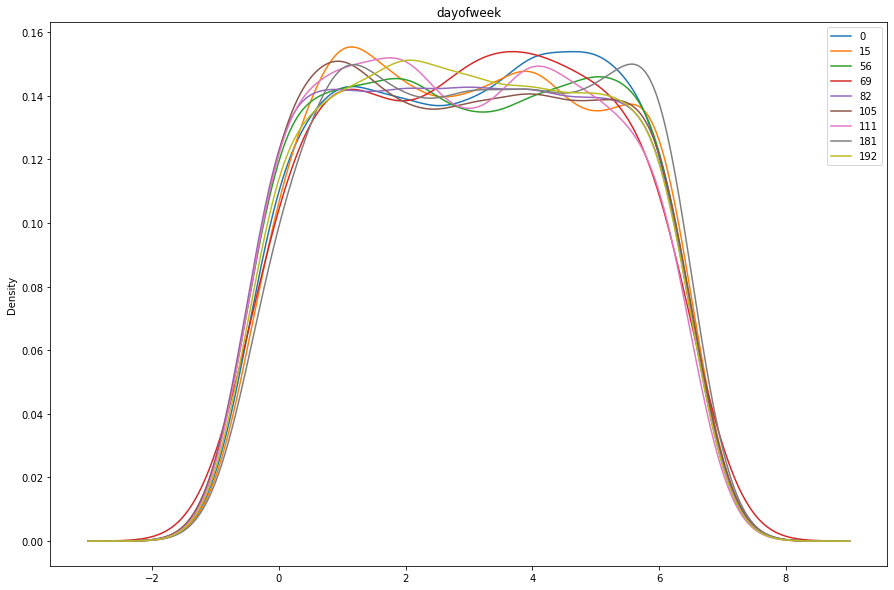

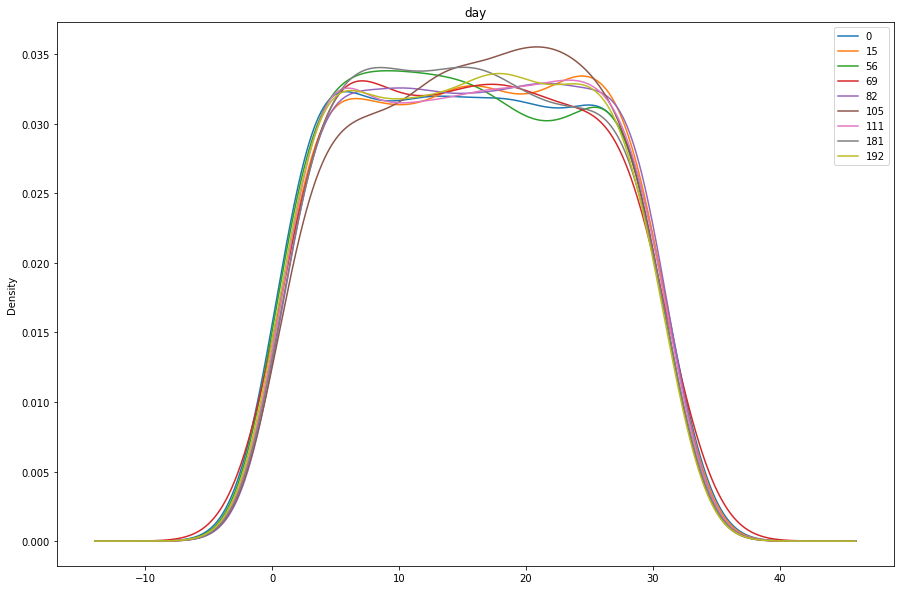

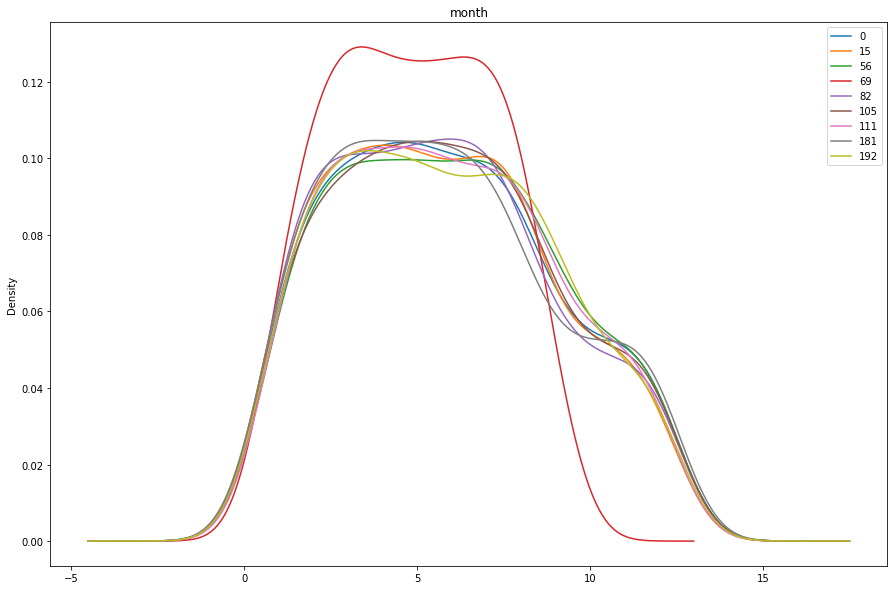

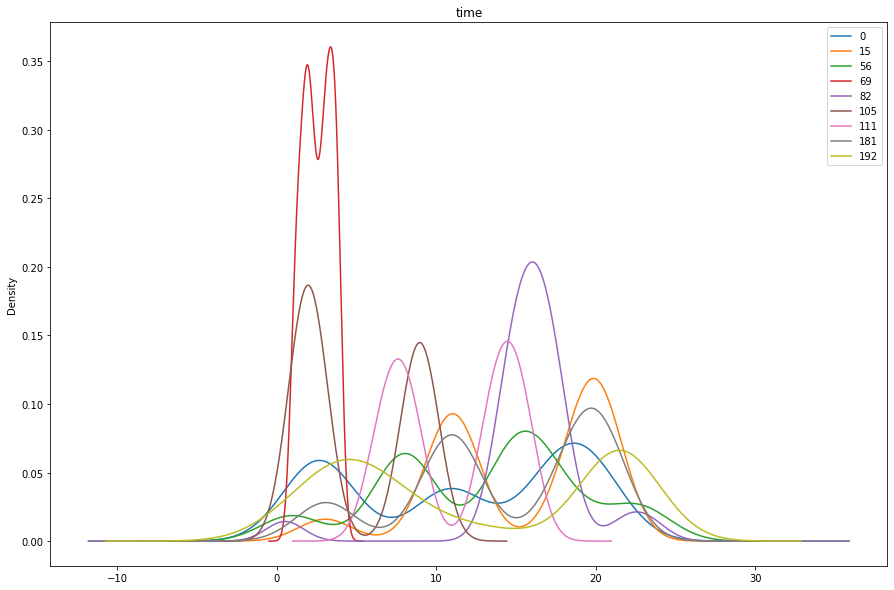

In [26]:
PERIODS = ["dayofweek", "day", "month", "time"]
for period in PERIODS:
    df.groupby("user_id")[period].plot.density(figsize=(15,10), legend=True, title=period)
    plt.show()

In [ ]:
#df = one_hot_encode(df, "user_id")
df = df.drop(columns="user_id")
df = one_hot_encode(df, "browser")
df = one_hot_encode(df, "os")
df = one_hot_encode(df, "location")

In [66]:
df.head()

is_joe  dayofweek       time  browser_Chrome  browser_Firefox  os_Ubuntu  \
0       0          6   9.050000               0                1          1   
1       1          5  10.216667               0                1          0   
2       0          5  14.416667               1                0          1   
3       0          4  19.233333               1                0          1   
4       0          4  21.366667               1                0          1   

   os_Windows 10  location_Canada/Toronto  location_France/Paris  \
0              0                        0                      0   
1              1                        0                      1   
2              0                        0                      1   
3              0                        0                      1   
4              0                        0                      0   

   location_USA/Chicago      date  
0                     1  1.266667  
1                     0  5.000000  
2                     0  6.600000  
3                     0  6.766667  
4                     1  6.533333

# 3. Models training

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn import metrics
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from typing import Optional
from sklearn.metrics import auc
from sklearn.metrics import make_scorer

In [ ]:
list(df.columns)

# 3.0 Splitting data
Stratified data split on train, validation (tuning hyperparameters) and test (checking final model performance.)

In [75]:
from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop(columns="is_joe")
y = df["is_joe"]

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.15,
                             random_state=0)
sss.get_n_splits(X, y)

for train_index, test_index in sss.split(X, y):
    _X_train, X_test = X.values[train_index], X.values[test_index]
    _y_train, y_test = y.values[train_index], y.values[test_index]

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.15,
                             random_state=0)
                             
sss.get_n_splits(_X_train, _y_train)

for train_index, validation_index in sss.split(_X_train, _y_train):
    X_train, X_val = X.values[train_index], X.values[validation_index]
    y_train, y_val = y.values[train_index], y.values[validation_index]

## 3.1 Model choosing

### 3.1.1 Metrics
Even before choosing model we need to define a metric that will be able to show performace of our model. For each model I've calculated F1 score, ROC curve and area under it, but these metrics aren't suitable for unbalanced datasets. Instead I've chosen Precision-Recall curve (area under it) as it gives reliable measurements.

In [34]:
def generate_metrics(model, X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame, draw_plots: Optional[bool] = True):
    print(type(model))
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
    precision_train, recall_train, _ = metrics.precision_recall_curve(y_train, model.predict_proba(X_train)[:, 1])


    print("\n>>> TRAINING - - - - - - - - - - - - - - - - - - - -")
    print("f1:", metrics.f1_score(y_train, model.predict(X_train)))
    print(f">>> ROC AUC score: {roc_auc_score(y_train, model.predict(X_train))}")
    print(f">>> Precision-Recall AUC score: {auc(recall_train, precision_train)}")
    ConfusionMatrixDisplay.from_predictions(y_train, model.predict(X_train))
    plt.show()
    print("\n>>> TESTING - - - - - - - - - - - - - - - - - - - -")
    print(">>> f1 score:", metrics.f1_score(y_test, model.predict(X_test)))  
    print(f">>> ROC AUC score: {roc_auc_score(y_test, y_pred_proba)}")
    print(f">>> Precision-Recall AUC score: {auc(recall, precision)}")

    ConfusionMatrixDisplay.from_predictions(y_test, model.predict(X_test))
    plt.show()
  
    print("\n>>> PLOTS - - - - - - - - - - - - - - - - - - - -")
    
    if draw_plots == True:
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        fpr_train, tpr_train, _ = metrics.roc_curve(y_train,  y_train_pred_proba)
        plt.plot(fpr,tpr, label="test")
        plt.plot(fpr_train, tpr_train, label="train")
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.title("ROC curve")
        plt.legend()
        plt.show()

        plt.plot(recall, precision, label="test")
        plt.plot(recall_train, precision_train, label="train")
        no_skill = len(y_test[y_test==1]) / len(y_test)
        plt.plot([0, 1], [no_skill, no_skill], linestyle="--", label="no skill", color="b")
        plt.ylabel('Precision')
        plt.xlabel('Recall')
        plt.title("Precision-recall curve")
        plt.legend()
        plt.show()

    return model


### 3.1.2 Model
I wanted to use random forest with under- and oversampling at first, but then I came across gradient boosting classifier. I haven't used it before so I've decided to try it. In cell below I made very simple and quick comparison that was supposed to compare different random forest approaches. I cpmpared two of them with GradientBoostingClassifier and XGBClassifier, eXtreme Gradient Boosting, which is an algorithm based on gradient boosted decision trees. It applies a better regularization technique to reduce overfitting. It also appeared to have best results with default parameters, so I've decided to stick to it.

In [ ]:
space = dict()
space['n_estimators'] = [100]
def score_func(y_test, y_pred_proba):
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
    return auc(recall, precision)

prec_recall_auc = make_scorer(score_func, greater_is_better = True, needs_proba = True)

models = [GradientBoostingClassifier(), XGBClassifier(), BalancedBaggingClassifier(), EasyEnsembleClassifier()]
best_score = 0
best_params = []
best_model = 0

for model in models:
    print(f"currently working on {type(model)}")
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    search = GridSearchCV(model, space, cv=cv, scoring = prec_recall_auc, n_jobs=-1)

    result = search.fit(X_train, y_train)

    if result.best_score_ > best_score:
        best_score = result.best_score_
        best_params = result.best_params_
        best_model = model

print(f'Best Score: {result.best_score_}')
print(f'Best Hyperparameters: {result.best_params_}')
print(f'Best model: {type(best_model)}')

## 3.2 Hyperparameter tuning

3.2.1 Tuning hyperparameters was long and every combination semeed to give unsatysfying results (~0.8 precision-recall score). It took many grid searches until I realised I forgot about early stopping. First run with it on basic settings resulted with ~0.9 score. I'm sure I could get better score with one more, big Grid Search, but it would take some time. Might run it over night and update it in the future.

In [ ]:
def score_func_prec_rec_curve(y_test, y_pred_proba):
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
    return auc(recall, precision)
prec_recall_auc = make_scorer(score_func_prec_rec_curve, greater_is_better = True, needs_proba = True)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
model = XGBClassifier()
space = dict()
space['n_estimators'] = [50, 100, 200]
space['max_depth'] = [5, 10, 15]
space["scale_pos_weight"] = [6, 11, 15]
space["gamma"] = [1, 10, 100]
space["subsample"] = [0.5, 0.75, 1.0]

eval_set = [(X_val, y_val)]
model = GridSearchCV(model, space, cv=cv, scoring=prec_recall_auc, n_jobs=-1, verbose=1)
result = model.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10)

print(result.best_score_)
print(result.best_params_)

Best found hyperparameters:
* 'gamma': 10
* 'max_depth': 5
* 'n_estimators': 100
* 'scale_pos_weight': 11
* 'subsample': 0.8

resulted with precision-recall auc score of 0.902.

<class 'sklearn.model_selection._search.GridSearchCV'>

>>> TRAINING - - - - - - - - - - - - - - - - - - - -
f1: 0.6706875753920386
>>> ROC AUC score: 0.9333172533102668
>>> Precision-Recall AUC score: 0.9089483388340082


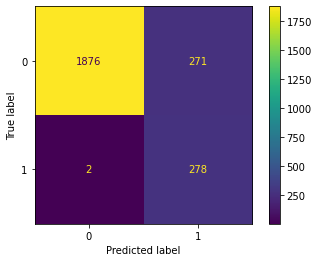


>>> TESTING - - - - - - - - - - - - - - - - - - - -
>>> f1 score: 0.6666666666666667
>>> ROC AUC score: 0.982545045045045
>>> Precision-Recall AUC score: 0.9018931417013548


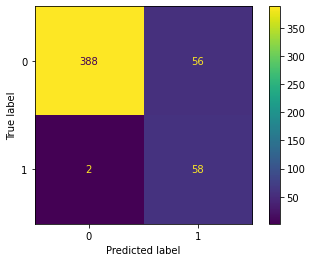


>>> PLOTS - - - - - - - - - - - - - - - - - - - -


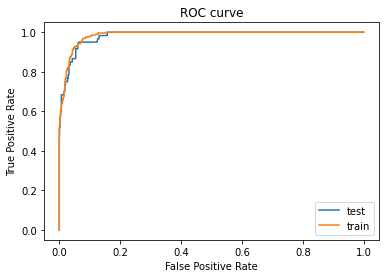

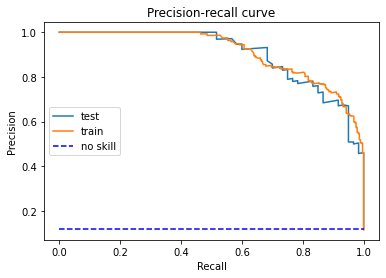

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     inter...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [10], 'max_depth': [5, 10],
                         'n_estimators': [100], 'scale_pos_weight': [11],
                         'subsample': [0.8]},
             scoring=make_scorer(score_func_prec_rec_curve, needs_proba=True),
             verbose=2)

In [94]:
generate_metrics(model, X_train, y_train, X_test, y_test)